# Street View House Numbers - Indexed Search

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import svhn
import graphics
import keras_utils
from keras.utils import np_utils


%matplotlib inline

max_digits = 7
image_size = (32,77)
checkpoint_path = 'checkpoint/model.hdf5'
resume_training = True

In [2]:
rawdata = svhn.read_process_h5('../inputs/train/digitStruct.mat')

In [4]:
def generateData(data, n=1000):    
    Ximg_flat = []
    Xidx_flat = []
    ycount_flat = []
    ycoord_flat = []
    ylabel_flat = []
    
    for datapoint in np.random.choice(data, size=n):
        img,rawsize = svhn.createImageData(datapoint, image_size)
        for i in range(0,datapoint['length']):
            Ximg_flat.append(img)
            Xidx_flat.append(i)
            ycount_flat.append(datapoint['length'])
            ycoord_flat.append(svhn.createCoordinates(datapoint, i, rawsize, image_size))
            ylabel_flat.append(datapoint['labels'][i])
            
    ylabel_flat = [0 if y==10 else int(y) for y in ylabel_flat]
    return np.array(Ximg_flat), np.array(Xidx_flat), np.array(ycount_flat), np.array(ycoord_flat), np.array(ylabel_flat)

Ximg, Xidx, ycount, ycoord, ylabel = generateData(rawdata, 33402)

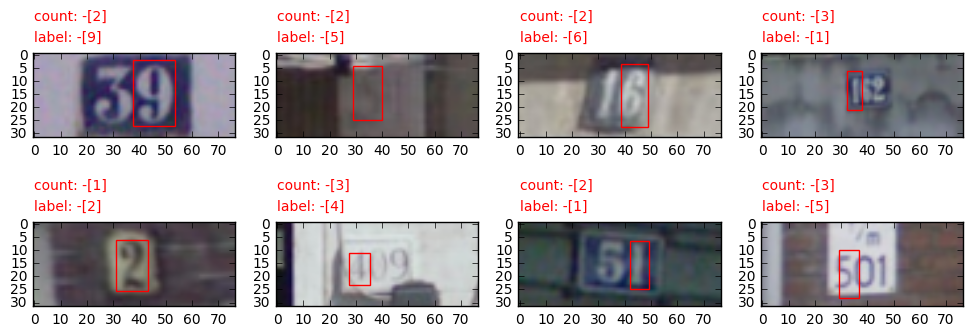

In [5]:
graphics.displaySamples(Ximg, ytrue=ylabel, ycounttrue=ycount, ycoordtrue=ycoord)

In [44]:
from keras.layers import Input, Dense, Merge, Flatten, Dropout, merge
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, Sequential

vision_model = Sequential()
vision_model.add(Convolution2D(32, 3, 3, input_shape=(image_size[0],image_size[1],3), activation='tanh', dim_ordering='tf'))
vision_model.add(Convolution2D(32, 3, 3, activation='relu', dim_ordering='tf'))
vision_model.add(Dropout(0.2))
vision_model.add(MaxPooling2D(pool_size=(2,2), dim_ordering='tf'))

vision_model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering='tf'))
vision_model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering='tf'))
vision_model.add(Dropout(0.2))
vision_model.add(MaxPooling2D(pool_size=(2,2), dim_ordering='tf'))

vision_model.add(Convolution2D(128, 3, 3, activation='relu', dim_ordering='tf'))
vision_model.add(MaxPooling2D(pool_size=(2,2), dim_ordering='tf'))
vision_model.add(Flatten())
vision_model.add(Dense(1024, activation='relu'))
vision_model.add(Dense(1024, activation='relu'))

image_in = Input(shape=(image_size[0],image_size[1],3), name='image_in')
encoded_image = vision_model(image_in)

# Create a counter using the vision model output
counter_out = Dense(256, activation='relu')(encoded_image)
counter_out = Dense(128, activation='relu')(encoded_image)
counter_out = Dense(max_digits, activation='softmax', name='counter_out')(counter_out)

index_in = Input(shape=(1,), name='index_in')
merged = merge([encoded_image, index_in], mode='concat')

label_out = Dense(1024, activation='relu')(merged)
label_out = Dense(512, activation='relu')(label_out)
label_out = Dense(10, activation='softmax', name='label_out')(label_out)

model = Model(input=[image_in,index_in], output=[counter_out, label_out])
model.compile(optimizer='adamax', loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])

In [45]:
# resume training if instructed and weights file exists
import os.path

if resume_training and os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

<IPython.core.display.Javascript object>


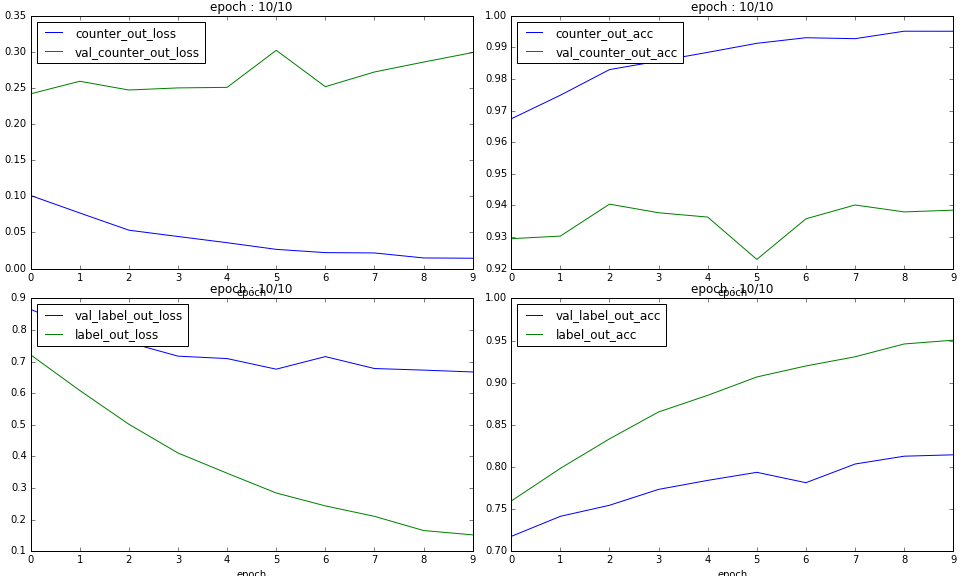

Train on 69484 samples, validate on 3658 samples
Epoch 1/10
69484/69484 [==============================] - 36s - loss: 0.8225 - counter_out_loss: 0.1012 - label_out_loss: 0.7213 - counter_out_acc: 0.9674 - label_out_acc: 0.7596 - val_loss: 1.1071 - val_counter_out_loss: 0.2420 - val_label_out_loss: 0.8651 - val_counter_out_acc: 0.9295 - val_label_out_acc: 0.7176
Epoch 2/10
69484/69484 [==============================] - 35s - loss: 0.6856 - counter_out_loss: 0.0770 - label_out_loss: 0.6086 - counter_out_acc: 0.9749 - label_out_acc: 0.7983 - val_loss: 1.0612 - val_counter_out_loss: 0.2594 - val_label_out_loss: 0.8018 - val_counter_out_acc: 0.9303 - val_label_out_acc: 0.7414
Epoch 3/10
69484/69484 [==============================] - 36s - loss: 0.5549 - counter_out_loss: 0.0532 - label_out_loss: 0.5017 - counter_out_acc: 0.9830 - label_out_acc: 0.8333 - val_loss: 1.0074 - val_counter_out_loss: 0.2473 - val_label_out_loss: 0.7602 - val_counter_out_acc: 0.9404 - val_label_out_acc: 0.7545
Epo

In [56]:
# DynamicPlot callback displays dynamically updated training metrics plots instead of default progress bars
# This gives a concise but dynamic training view instead of thousands of lines of epoch metrics
%matplotlib notebook
fig,axes = plt.subplots(2,2, figsize=(13.5,8))
fig.tight_layout()
counterLossPlot = keras_utils.DynamicPlot(metrics=['counter_out_loss','val_counter_out_loss'], axes=axes[0,0])
counterAccPlot = keras_utils.DynamicPlot(metrics=['counter_out_acc','val_counter_out_acc'], axes=axes[0,1])
labelLossPlot = keras_utils.DynamicPlot(metrics=['label_out_loss','val_label_out_loss'], axes=axes[1,0])
labelAccPlot = keras_utils.DynamicPlot(metrics=['label_out_acc','val_label_out_acc'], axes=axes[1,1])

# checkpoint the model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_label_out_acc', verbose=0, save_best_only=True, mode='max')

history = model.fit([Ximg,Xidx], 
                    [np_utils.to_categorical(ycount, max_digits),np_utils.to_categorical(ylabel, 10)], 
                    nb_epoch=10, 
                    batch_size=512, 
                    shuffle=True, 
                    validation_split=0.05,
                    verbose=1,
                    callbacks=[counterLossPlot,counterAccPlot,labelLossPlot,labelAccPlot,checkpoint])

In [75]:
Ximg_t, Xidx_t, ycount_t, ycoord_t, ylabel_t = generateData(rawdata, 1000)
ycount_p,ylabel_p = model.predict([Ximg_t,Xidx_t])
ycount_p = np.argmax(ycount_p, axis=1)
ylabel_p = np.argmax(ylabel_p, axis=1)

In [76]:
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print "Counter metrics :"
print classification_report(ycount_t, ycount_p)

print "Label metrics :"
print classification_report(ylabel_t, ylabel_p)

Counter metrics :
             precision    recall  f1-score   support

          1       0.85      0.90      0.87       136
          2       0.94      0.96      0.95      1132
          3       0.93      0.90      0.91       804
          4       0.82      0.77      0.79       120

avg / total       0.92      0.92      0.92      2192

Label metrics :
             precision    recall  f1-score   support

          0       0.87      0.75      0.81       155
          1       0.88      0.88      0.88       423
          2       0.89      0.86      0.87       320
          3       0.81      0.81      0.81       250
          4       0.79      0.87      0.83       224
          5       0.76      0.86      0.81       211
          6       0.83      0.80      0.82       176
          7       0.81      0.80      0.81       158
          8       0.71      0.68      0.69       137
          9       0.82      0.76      0.79       138

avg / total       0.83      0.83      0.83      2192



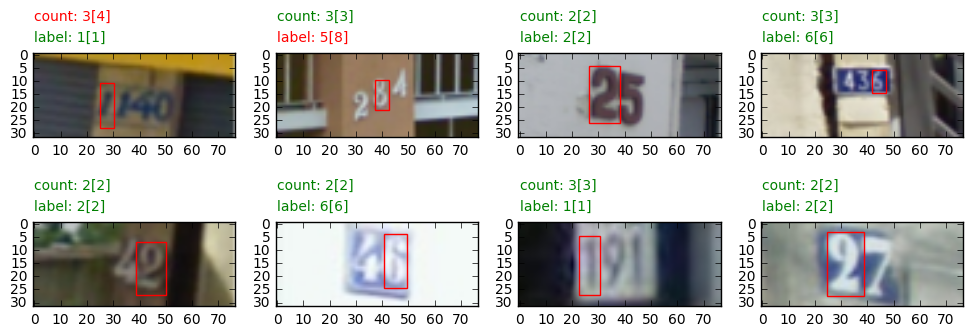

In [77]:
graphics.displaySamples(Ximg_t, ytrue=ylabel_t, ypred=ylabel_p, ycounttrue=ycount_t, ycountpred=ycount_p, ycoordtrue=ycoord_t)

(32, 30, 75)


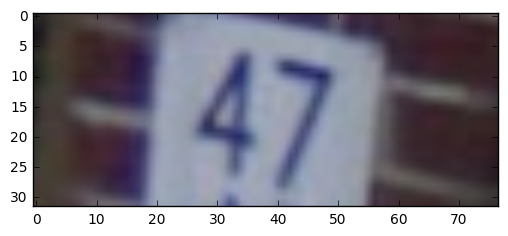

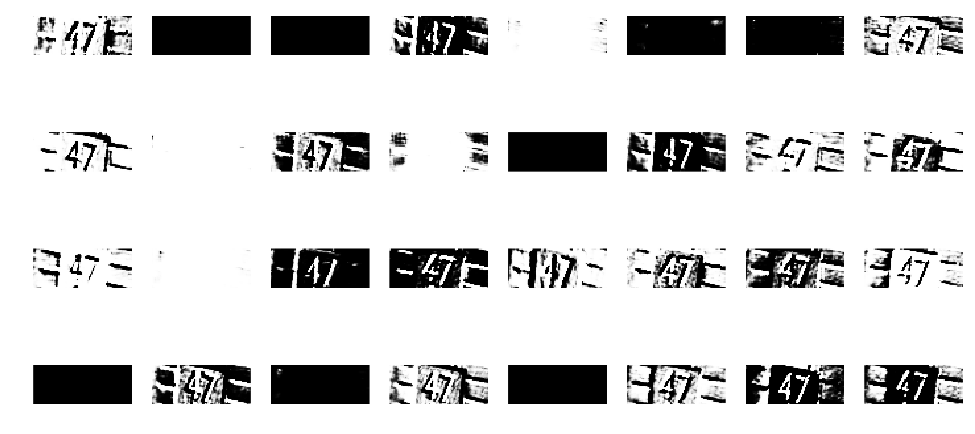

In [74]:
showdigit = 0
layer = 0
        
plt.imshow(Ximg_t[showdigit])
graphics.showCNNConv(vision_model, layer, Ximg_t[showdigit])